## 重新整理一下上一部分的代码
## 数据读取

In [1]:
# Colab 专有命令
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab Notebooks/Lesson7\ RNN

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Lesson7 RNN


In [0]:
from io import open
import glob
import os
import matplotlib.pyplot as plt
import unicodedata
import string
import numpy as np
import time
import math
import random
import torch
import torch.nn as nn

In [3]:
def find_files(path): return glob.glob(path)

print(find_files('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) 
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

['data/names/Italian.txt', 'data/names/Irish.txt', 'data/names/Arabic.txt', 'data/names/French.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/Greek.txt', 'data/names/German.txt', 'data/names/English.txt', 'data/names/Chinese.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Russian.txt', 'data/names/Vietnamese.txt', 'data/names/Spanish.txt']
Slusarski


In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)

18


## 查看训练时间方法

In [0]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [0]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


## 数据采样

In [7]:
# Find letter index from all_letters, e.g. "a" = 0 
def letter_to_index(letter):
    return all_letters.find(letter)

# 将一个词转成tensor，shape（1，词的字母数， 字母数（n_letters））
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

# 将多个词转成tensor，shape（词数，最长词的字母数， 字母数（n_letters））
def lines_to_tensor(lines):
    tensor = torch.zeros(len(lines[0]), len(lines), n_letters)
    for i, line in enumerate(lines):
        for li, letter in enumerate(line):
            tensor[li][i][letter_to_index(letter)] = 1
    return tensor

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning(n_batch):
    categories = [sample(all_categories) for i in range(n_batch)]
    lines = [sample(category_lines[category]) for category in categories]
    max_lines_count = np.max([len(item) for item in lines])
    lines = [' '*(max_lines_count - len(line)) + line for line in lines]
    
    categories_tensor = torch.tensor([all_categories.index(category) for category in categories], dtype=torch.long)
    lines_tensor = lines_to_tensor(lines)
    return categories, lines, categories_tensor, lines_tensor

for i in range(10):
    categories, lines, categories_tensor, lines_tensor = sample_trainning(4)
    print('categories =', categories, '/ lines =', lines) 


categories = ['Irish', 'Arabic', 'Portuguese', 'Portuguese'] / lines = ["O'Mahoney", '    Srour', '     Cruz', 'Fernandes']
categories = ['Scottish', 'Polish', 'Dutch', 'Dutch'] / lines = [' Robertson', '     Gajos', ' Nifterick', 'Amersvoort']
categories = ['English', 'Greek', 'Greek', 'Greek'] / lines = ['           Peck', 'Alexandropoulos', '        Kringos', '       Paraskos']
categories = ['Italian', 'Vietnamese', 'French', 'Vietnamese'] / lines = ['Arrighi', '    Thi', ' Dubois', '     Ma']
categories = ['Czech', 'Japanese', 'Russian', 'Irish'] / lines = ['Jarzembowski', '        Muro', ' Halymbadzha', '      Giolla']
categories = ['Scottish', 'German', 'Scottish', 'Chinese'] / lines = ['Mcgregor', 'Eckstein', '   Burns', '    Weng']
categories = ['Portuguese', 'Dutch', 'Scottish', 'Polish'] / lines = [' Fernandes', '   Rumpade', 'Williamson', ' Krakowski']
categories = ['Scottish', 'Arabic', 'Czech', 'Dutch'] / lines = ['Morrison', ' Mustafa', ' Nemecek', '    Alst']
categories 

##训练方法

In [0]:
# 适用于RNN GRU
def _train_model(model, category_tensor, line_tensor, lossObj, device, optimizer, n_batch):
    hidden = model.initHidden(n_batch)

    for i in range(line_tensor.size()[0]):
        char_tensor = line_tensor[i].to(device)
        hidden = hidden.to(device)
        output, hidden = model(char_tensor, hidden)

    loss = lossObj(output.to(device), category_tensor.to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

def categories_from_output(output):
    top_n, top_i = output.topk(1,dim=1)
    category_i_S = top_i.reshape(-1)
    return np.array([all_categories[category_i] for category_i in category_i_S]), category_i_S.cpu().data.numpy()

def train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch,
                  train_model_func = _train_model, 
                  lossObj = nn.CrossEntropyLoss()):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
   
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    
    start = time.time()
    
    for iter in range(1, n_iters + 1):
        categories, lines, categories_tensor, lines_tensor = sample_trainning(n_batch)
        output, loss = train_model_func(model, categories_tensor, lines_tensor, lossObj, device, optimizer, n_batch)
        current_loss += loss
    
        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categories_from_output(output)
            correct = '✓' if guess[0] == categories[0] else '✗ (%s)' % categories[0]
            correct_count = len([item for item in (guess == categories) if item == True])
            print('%d %d%% (%s) %.4f acc=%.4f %s / %s %s' % \
                  (iter, iter / n_iters * 100, time_since(start), loss, correct_count / n_batch, lines[0], guess[0], correct))
    
        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    
    return model, all_losses

# 评估方法

In [0]:
def evaluate(model, line_tensor, n_batch):
    hidden = model.initHidden(n_batch)

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

def predict(model, input_line, evaluate_func = evaluate, n_predictions=3):
    print('\n> %s' % input_line)
    model = model.cpu()

    model.eval()
    with torch.no_grad():
        output = evaluate_func(model, line_to_tensor(input_line), 1)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

def get_train_acc(model, evaluate_func = evaluate):
    model.eval()
    all_correct_count = 0
    all_line_count = 0
    for category in all_categories:
        correct_count = 0
        for line in category_lines[category]:
            output = evaluate_func(model, line_to_tensor(line), 1)
            topv, topi = output.topk(1, 1)
            category_index = topi[0][0].item()
            if all_categories[category_index] == category :
                correct_count += 1
                all_correct_count += 1
        sub_all_line_count = len(category_lines[category])
        all_line_count += sub_all_line_count
        print('%s 总个数：%d, 正确个数: %d, acc: %.4f'\
              %(category, sub_all_line_count , correct_count, correct_count/sub_all_line_count))
    print('所有分类总个数：%d, 正确个数: %d, acc: %.4f'\
              %(all_line_count, all_correct_count, all_correct_count/all_line_count))


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cpu


In [0]:
%matplotlib inline

## 上一部分用到的模型


In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, n_batch):
        return torch.zeros(n_batch, self.hidden_size)

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.r_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.z_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.h_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input:torch.Tensor, hidden:torch.Tensor):
        combined = torch.cat((input, hidden), 1)
        r = self.sigmoid(self.r_gate(combined))
        z = self.sigmoid(self.z_gate(combined))
        combined2 = torch.cat((r * hidden, input), 1)
        h_hat = self.tanh(self.h_gate(combined2))
        hidden = (1-z) * hidden + z * h_hat
        output = self.softmax(self.i2o(hidden))
        return output, hidden

    def initHidden(self, n_batch):
        return torch.zeros(n_batch, self.hidden_size)

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

> todo

In [0]:
class RNN_module(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_module, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden

# 串联RNN
class SeriesRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SeriesRNN, self).__init__()

        self.hidden_size = hidden_size

        self.rnn1 = RNN_module(input_size, hidden_size, hidden_size)
        self.rnn2 = RNN_module(hidden_size, hidden_size, hidden_size)
        self.activation1 = nn.Tanh()
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        rnn1_output, hidden = self.rnn1(input, hidden)
        rnn1_output, hidden = self.activation1(rnn1_output), self.activation1(hidden)
        rnn2_output, hidden = self.rnn2(rnn1_output, hidden)
        rnn2_output, hidden = self.activation1(rnn2_output), self.activation1(hidden)
        
        output = self.i2o(rnn2_output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, n_batch):
        return torch.zeros(n_batch, self.hidden_size)
    
# 并联RNN  (先并联再串联)
class ParallelRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ParallelRNN, self).__init__()

        self.hidden_size = hidden_size

        self.rnn1 = RNN_module(input_size, hidden_size, hidden_size)
        self.rnn2 = RNN_module(input_size, hidden_size, hidden_size)
        self.activation1 = nn.Tanh()
        self.activation2 = nn.Sigmoid()
        self.rnn3 = RNN_module(hidden_size , hidden_size , hidden_size)
        self.activation3 = nn.Tanh()
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        rnn1_output, hidden1 = self.rnn1(input, hidden)
        rnn1_output, hidden1 = self.activation1(rnn1_output), self.activation1(hidden1)
        rnn2_output, hidden2 = self.rnn2(input, hidden)
        rnn2_output, hidden2 = self.activation2(rnn2_output), self.activation2(hidden2)
        
        output, hidden = self.rnn3(rnn1_output * rnn2_output, hidden1 * hidden2)
        output, hidden = self.activation3(output), self.activation3(hidden)
        
        output = self.i2o(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, n_batch):
        return torch.zeros(n_batch, self.hidden_size)
    

In [0]:
# 构建模型 
n_hidden = 128
model = RNN(n_letters, n_hidden, n_categories)

In [0]:
#model = torch.load("RNN")

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
1000 0% (0m 3s) 2.4869 acc=0.1250   Tsukade / Japanese ✓
2000 0% (0m 7s) 2.2807 acc=0.3750     Liang / Chinese ✓
3000 0% (0m 10s) 2.2797 acc=0.2500        Tieu / Chinese ✗ (Vietnamese)
4000 0% (0m 14s) 2.3426 acc=0.3750  Wyrzyk / Polish ✓
5000 1% (0m 17s) 2.1388 acc=0.3750    Scott / English ✗ (Scottish)
6000 1% (0m 21s) 1.8903 acc=0.5000     Duguay / Arabic ✗ (French)
7000 1% (0m 24s) 2.0688 acc=0.2500      Kieu / Chinese ✗ (Vietnamese)
8000 1% (0m 28s) 2.1744 acc=0.3750    Santos / Arabic ✗ (Spanish)
9000 1% (0m 31s) 2.0811 acc=0.5000      Rosa / Spanish ✗ (Italian)
10000 2% (0m 35s) 2.4526 acc=0.1250  Rousses / Dutch ✗ (Greek)
11000 2% (0m 39s) 1.7457 acc=0.5000       Aldred / Dutch ✗ (English)
12000 2% (0m 42s) 1.6588 acc=0.5000   Tsukade / Japanese ✓
13000 2% (0m 46s) 1.9551 acc=0.2500  Rusnak / Scottish ✗ (Polish)
14000 2% (0m

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Italian 总个数：709, 正确个数: 541, acc: 0.7630
Irish 总个数：232, 正确个数: 187, acc: 0.8060
Arabic 总个数：2000, 正确个数: 1822, acc: 0.9110
French 总个数：277, 正确个数: 186, acc: 0.6715
Czech 总个数：519, 正确个数: 286, acc: 0.5511
Dutch 总个数：297, 正确个数: 201, acc: 0.6768
Greek 总个数：203, 正确个数: 194, acc: 0.9557
German 总个数：724, 正确个数: 437, acc: 0.6036
English 总个数：3668, 正确个数: 1409, acc: 0.3841
Chinese 总个数：268, 正确个数: 192, acc: 0.7164
Japanese 总个数：991, 正确个数: 844, acc: 0.8517
Korean 总个数：94, 正确个数: 83, acc: 0.8830
Polish 总个数：139, 正确个数: 128, acc: 0.9209
Portuguese 总个数：74, 正确个数: 69, acc: 0.9324
Scottish 总个数：100, 正确个数: 85, acc: 0.8500
Russian 总个数：9408, 正确个数: 7283, acc: 0.7741
Vietnamese 总个数：73, 正确个数: 58, acc: 0.7945
Spanish 总个数：298, 正确个数: 199, acc: 0.6678
所有分类总个数：20074, 正确个数: 14204, acc: 0.7076


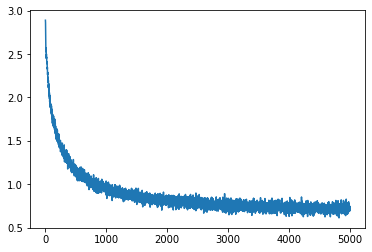

In [59]:
print(model)
model.train()
model = model.to(device)
# 超参数
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 500000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 100
n_batch = 8
# 训练
model, all_losses = train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch)
torch.save(model, "RNN")
# 评估
print("评估")
predict(model, 'Dovesky')
predict(model, 'Jackson')
predict(model, 'Satoshi')
predict(model, 'Liu')
predict(model, 'Sun')
predict(model, 'Tian')
plt.plot(all_losses)
get_train_acc(model)

In [0]:
# 构建模型 
n_hidden = 128
model = SeriesRNN(n_letters, n_hidden, n_categories)

In [0]:
#model = torch.load("SeriesRNN")

SeriesRNN(
  (rnn1): RNN_module(
    (i2h): Linear(in_features=185, out_features=128, bias=True)
    (i2o): Linear(in_features=185, out_features=128, bias=True)
  )
  (rnn2): RNN_module(
    (i2h): Linear(in_features=256, out_features=128, bias=True)
    (i2o): Linear(in_features=256, out_features=128, bias=True)
  )
  (activation1): Tanh()
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
1000 0% (0m 8s) 2.0115 acc=0.3750 Lefurgey / English ✗ (French)
2000 0% (0m 17s) 1.7681 acc=0.5000       Saliba / Japanese ✗ (Arabic)
3000 0% (0m 26s) 1.9959 acc=0.6250      Luong / Vietnamese ✓
4000 0% (0m 34s) 1.8313 acc=0.3750    Vennen / Dutch ✓
5000 1% (0m 43s) 1.9385 acc=0.5000       Yeo / Korean ✓
6000 1% (0m 52s) 1.5309 acc=0.3750   Jedynak / Polish ✓
7000 1% (1m 0s) 1.3024 acc=0.5000      Abadi / Japanese ✗ (Arabic)
8000 1% (1m 9s) 1.7856 acc=0.2500      Otten / German ✗ (Dutch)
9000 1% (1m 18s) 1.2845 acc=0.7500        Doan / Vietnamese ✓
10000 2% (1m 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SeriesRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN_module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Italian 总个数：709, 正确个数: 675, acc: 0.9520
Irish 总个数：232, 正确个数: 226, acc: 0.9741
Arabic 总个数：2000, 正确个数: 2000, acc: 1.0000
French 总个数：277, 正确个数: 256, acc: 0.9242
Czech 总个数：519, 正确个数: 505, acc: 0.9730
Dutch 总个数：297, 正确个数: 286, acc: 0.9630
Greek 总个数：203, 正确个数: 203, acc: 1.0000
German 总个数：724, 正确个数: 657, acc: 0.9075
English 总个数：3668, 正确个数: 3343, acc: 0.9114
Chinese 总个数：268, 正确个数: 242, acc: 0.9030
Japanese 总个数：991, 正确个数: 984, acc: 0.9929
Korean 总个数：94, 正确个数: 87, acc: 0.9255
Polish 总个数：139, 正确个数: 139, acc: 1.0000
Portuguese 总个数：74, 正确个数: 74, acc: 1.0000
Scottish 总个数：100, 正确个数: 98, acc: 0.9800
Russian 总个数：9408, 正确个数: 9055, acc: 0.9625
Vietnamese 总个数：73, 正确个数: 72, acc: 0.9863
Spanish 总个数：298, 正确个数: 251, acc: 0.8423
所有分类总个数：20074, 正确个数: 19153, acc: 0.9541


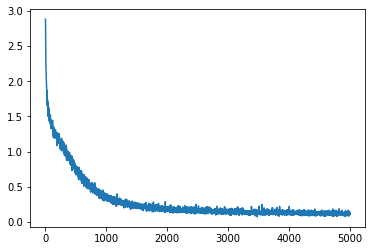

In [65]:
print(model)
model.train()
model = model.to(device)
# 超参数
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 500000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 100
n_batch = 8
# 训练
model, all_losses = train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch)
torch.save(model, "SeriesRNN")
# 评估
print("评估")
predict(model, 'Dovesky')
predict(model, 'Jackson')
predict(model, 'Satoshi')
predict(model, 'Liu')
predict(model, 'Sun')
predict(model, 'Tian')
plt.plot(all_losses)
get_train_acc(model)

In [0]:
# 构建模型 
n_hidden = 128
model = ParallelRNN(n_letters, n_hidden, n_categories)

In [0]:
#model = torch.load("ParallelRNN")

ParallelRNN(
  (rnn1): RNN_module(
    (i2h): Linear(in_features=185, out_features=128, bias=True)
    (i2o): Linear(in_features=185, out_features=128, bias=True)
  )
  (rnn2): RNN_module(
    (i2h): Linear(in_features=185, out_features=128, bias=True)
    (i2o): Linear(in_features=185, out_features=128, bias=True)
  )
  (activation1): Tanh()
  (activation2): Sigmoid()
  (rnn3): RNN_module(
    (i2h): Linear(in_features=256, out_features=128, bias=True)
    (i2o): Linear(in_features=256, out_features=128, bias=True)
  )
  (activation3): Tanh()
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
1000 0% (0m 14s) 2.1251 acc=0.2500    Hughes / German ✗ (Scottish)
2000 0% (0m 28s) 1.9249 acc=0.3750    Faucheux / French ✓
3000 0% (0m 42s) 1.6463 acc=0.3750 Antonelli / Italian ✓
4000 0% (0m 57s) 1.6081 acc=0.6250      Ilyunin / Russian ✓
5000 1% (1m 12s) 1.8155 acc=0.3750   Alber / German ✗ (English)
6000 1% (1m 26s) 1.8505 acc=0.5000  Schroeder / German 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ParallelRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN_module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


评估

> Dovesky
(-0.00) Russian
(-11.08) English
(-12.11) Czech

> Jackson
(-0.01) Scottish
(-4.59) English
(-9.90) Greek

> Satoshi
(-0.00) Japanese
(-11.13) Russian
(-15.40) English

> Liu
(-0.00) Chinese
(-8.58) Vietnamese
(-8.60) Russian

> Sun
(-0.20) Korean
(-1.72) Chinese
(-10.12) Japanese

> Tian
(-0.04) Chinese
(-3.29) English
(-5.57) Japanese
Italian 总个数：709, 正确个数: 671, acc: 0.9464
Irish 总个数：232, 正确个数: 225, acc: 0.9698
Arabic 总个数：2000, 正确个数: 2000, acc: 1.0000
French 总个数：277, 正确个数: 264, acc: 0.9531
Czech 总个数：519, 正确个数: 503, acc: 0.9692
Dutch 总个数：297, 正确个数: 292, acc: 0.9832
Greek 总个数：203, 正确个数: 203, acc: 1.0000
German 总个数：724, 正确个数: 647, acc: 0.8936
English 总个数：3668, 正确个数: 3334, acc: 0.9089
Chinese 总个数：268, 正确个数: 242, acc: 0.9030
Japanese 总个数：991, 正确个数: 982, acc: 0.9909
Korean 总个数：94, 正确个数: 91, acc: 0.9681
Polish 总个数：139, 正确个数: 137, acc: 0.9856
Portuguese 总个数：74, 正确个数: 74, acc: 1.0000
Scottish 总个数：100, 正确个数: 100, acc: 1.0000
Russian 总个数：9408, 正确个数: 9157, acc: 0.9733
Vietnamese 总个

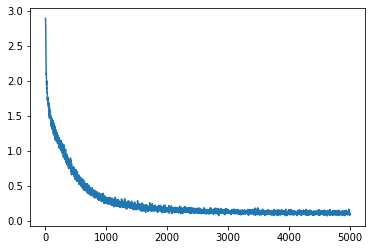

In [15]:
print(model)
model.train()
model = model.to(device)
# 超参数
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 500000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 100
n_batch = 8
# 训练
model, all_losses = train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch)
torch.save(model, "ParallelRNN")
# 评估
print("评估")
predict(model, 'Dovesky')
predict(model, 'Jackson')
predict(model, 'Satoshi')
predict(model, 'Liu')
predict(model, 'Sun')
predict(model, 'Tian')
plt.plot(all_losses)
get_train_acc(model)

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

> todo

In [0]:
# 构建模型 
n_hidden = 128
model = RNN(n_letters, n_hidden, n_categories)

In [0]:
#model = torch.load("RNN_NLLLoss")

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
1000 0% (0m 4s) 2.7771 acc=0.0000 Lemieux / Greek ✗ (French)
2000 0% (0m 8s) 2.5108 acc=0.2500       Yee / Chinese ✓
3000 0% (0m 12s) 2.6408 acc=0.1250   Jukalov / Czech ✗ (Russian)
4000 0% (0m 16s) 2.5852 acc=0.1250    Dufort / Portuguese ✗ (French)
5000 1% (0m 20s) 2.0442 acc=0.1250 Sneijders / Portuguese ✗ (Dutch)
6000 1% (0m 24s) 1.8600 acc=0.5000   Peatain / Irish ✓
7000 1% (0m 28s) 2.1248 acc=0.3750       Shaw / Chinese ✗ (Scottish)
8000 1% (0m 32s) 1.8145 acc=0.5000     Mansour / Arabic ✓
9000 1% (0m 37s) 1.7777 acc=0.5000   Acciai / Italian ✓
10000 2% (0m 41s) 1.7601 acc=0.6250   Touma / Japanese ✗ (Arabic)
11000 2% (0m 45s) 1.6850 acc=0.3750      Caro / Vietnamese ✗ (Spanish)
12000 2% (0m 49s) 1.6524 acc=0.5000         Dam / Vietnamese ✓
13000 2% (0m 53s) 1.7159 acc=0.3750  Esteves / Dutch ✗ (Portuguese)
14000 2% (0m 57s) 1

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Italian 总个数：709, 正确个数: 524, acc: 0.7391
Irish 总个数：232, 正确个数: 195, acc: 0.8405
Arabic 总个数：2000, 正确个数: 1981, acc: 0.9905
French 总个数：277, 正确个数: 187, acc: 0.6751
Czech 总个数：519, 正确个数: 280, acc: 0.5395
Dutch 总个数：297, 正确个数: 227, acc: 0.7643
Greek 总个数：203, 正确个数: 196, acc: 0.9655
German 总个数：724, 正确个数: 409, acc: 0.5649
English 总个数：3668, 正确个数: 1259, acc: 0.3432
Chinese 总个数：268, 正确个数: 202, acc: 0.7537
Japanese 总个数：991, 正确个数: 859, acc: 0.8668
Korean 总个数：94, 正确个数: 80, acc: 0.8511
Polish 总个数：139, 正确个数: 127, acc: 0.9137
Portuguese 总个数：74, 正确个数: 72, acc: 0.9730
Scottish 总个数：100, 正确个数: 86, acc: 0.8600
Russian 总个数：9408, 正确个数: 7318, acc: 0.7778
Vietnamese 总个数：73, 正确个数: 60, acc: 0.8219
Spanish 总个数：298, 正确个数: 200, acc: 0.6711
所有分类总个数：20074, 正确个数: 14262, acc: 0.7105


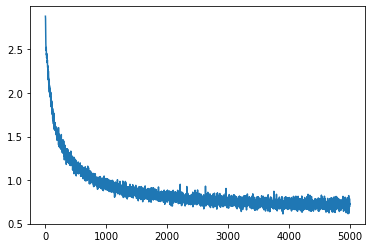

In [17]:
print(model)
model.train()
model = model.to(device)
# 超参数
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 500000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 100
n_batch = 8
# 训练
model, all_losses = train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch, lossObj=nn.NLLLoss())
torch.save(model, "RNN_NLLLoss")
# 评估
print("评估")
predict(model, 'Dovesky')
predict(model, 'Jackson')
predict(model, 'Satoshi')
predict(model, 'Liu')
predict(model, 'Sun')
predict(model, 'Tian')
plt.plot(all_losses)
get_train_acc(model)

In [0]:
# 构建模型 
n_hidden = 128
model = GRU(n_letters, n_hidden, n_categories)

In [0]:
#model = torch.load("GRU_NLLLoss")

GRU(
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (r_gate): Linear(in_features=185, out_features=128, bias=True)
  (z_gate): Linear(in_features=185, out_features=128, bias=True)
  (h_gate): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
1000 0% (0m 10s) 2.3478 acc=0.2500   Caomh / Czech ✗ (Irish)
2000 0% (0m 20s) 2.5254 acc=0.3750         Hay / Vietnamese ✗ (Scottish)
3000 0% (0m 30s) 1.9275 acc=0.3750    Chevrolet / Greek ✗ (German)
4000 0% (0m 40s) 2.1288 acc=0.1250   Kirkwood / Russian ✗ (English)
5000 1% (0m 50s) 1.8850 acc=0.5000 Burdett / French ✗ (English)
6000 1% (1m 0s) 2.2594 acc=0.3750    Lyon / Vietnamese ✗ (French)
7000 1% (1m 10s) 2.0061 acc=0.2500       Mai / Chinese ✗ (Vietnamese)
8000 1% (1m 20s) 1.8680 acc=0.5000      Daugule / English ✗ (Russian)
9000 1% (1m 30s) 2.1379 acc=0.3750     Ping / Vietnamese ✗ (Chinese)
10000 2% (1m 40s) 1.3501 acc=0.5000 Trnkova / Czech ✓
11000 2% 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Italian 总个数：709, 正确个数: 672, acc: 0.9478
Irish 总个数：232, 正确个数: 222, acc: 0.9569
Arabic 总个数：2000, 正确个数: 2000, acc: 1.0000
French 总个数：277, 正确个数: 257, acc: 0.9278
Czech 总个数：519, 正确个数: 490, acc: 0.9441
Dutch 总个数：297, 正确个数: 281, acc: 0.9461
Greek 总个数：203, 正确个数: 203, acc: 1.0000
German 总个数：724, 正确个数: 648, acc: 0.8950
English 总个数：3668, 正确个数: 3275, acc: 0.8929
Chinese 总个数：268, 正确个数: 244, acc: 0.9104
Japanese 总个数：991, 正确个数: 981, acc: 0.9899
Korean 总个数：94, 正确个数: 72, acc: 0.7660
Polish 总个数：139, 正确个数: 139, acc: 1.0000
Portuguese 总个数：74, 正确个数: 73, acc: 0.9865
Scottish 总个数：100, 正确个数: 99, acc: 0.9900
Russian 总个数：9408, 正确个数: 8961, acc: 0.9525
Vietnamese 总个数：73, 正确个数: 61, acc: 0.8356
Spanish 总个数：298, 正确个数: 252, acc: 0.8456
所有分类总个数：20074, 正确个数: 18930, acc: 0.9430


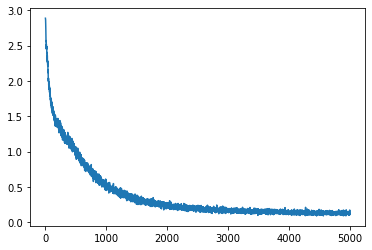

In [19]:
print(model)
model.train()
model = model.to(device)
# 超参数
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 500000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 100
n_batch = 8
# 训练
model, all_losses = train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch, lossObj=nn.NLLLoss())
torch.save(model, "GRU_NLLLoss")
# 评估
print("评估")
predict(model, 'Dovesky')
predict(model, 'Jackson')
predict(model, 'Satoshi')
predict(model, 'Liu')
predict(model, 'Sun')
predict(model, 'Tian')
plt.plot(all_losses)
get_train_acc(model)

## 列个表整体看一下

<table class="MsoNormalTable" border="0" cellspacing="0" style="border-collapse:collapse;width:1151.1000pt;margin-left:4.6500pt;
mso-table-layout-alt:fixed;border:none;mso-padding-alt:0.0000pt 0.0000pt 0.0000pt 0.0000pt ;"><tbody><tr style="height:13.5000pt;"><td width="161" valign="center" nowrap="" style="width:120.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:1.0000pt solid rgb(75,172,198);
mso-border-left-alt:1.0000pt solid rgb(75,172,198);border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:1.0000pt solid rgb(75,172,198);mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.5000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.5000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><b><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-weight:bold;font-style:normal;font-size:11.0000pt;
mso-font-kerning:0.0000pt;">模型</span></b><b><span style="font-family:宋体;color:rgb(0,0,0);font-weight:bold;
font-style:normal;font-size:11.0000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></b></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:1.0000pt solid rgb(75,172,198);mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.5000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.5000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><b><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-weight:bold;font-style:normal;font-size:11.0000pt;
mso-font-kerning:0.0000pt;">训练次数</span></b><b><span style="font-family:宋体;color:rgb(0,0,0);font-weight:bold;
font-style:normal;font-size:11.0000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></b></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:1.0000pt solid rgb(75,172,198);mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.5000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.5000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><b><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-weight:bold;font-style:normal;font-size:11.0000pt;
mso-font-kerning:0.0000pt;">学习率</span></b><b><span style="font-family:宋体;color:rgb(0,0,0);font-weight:bold;
font-style:normal;font-size:11.0000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></b></p></td><td width="95" valign="center" nowrap="" style="width:71.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:1.0000pt solid rgb(75,172,198);mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.5000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.5000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><b><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-weight:bold;font-style:normal;font-size:11.0000pt;
mso-font-kerning:0.0000pt;">batch大小</span></b><b><span style="font-family:宋体;color:rgb(0,0,0);font-weight:bold;
font-style:normal;font-size:11.0000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></b></p></td><td width="146" valign="center" nowrap="" style="width:109.5000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:1.0000pt solid rgb(75,172,198);mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.5000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.5000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><b><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-weight:bold;font-style:normal;font-size:11.0000pt;
mso-font-kerning:0.0000pt;">训练耗时（有用CPU，也有用TPU</span></b><b><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-weight:bold;font-style:normal;font-size:11.0000pt;
mso-font-kerning:0.0000pt;">训练</span></b><b><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-weight:bold;font-style:normal;font-size:11.0000pt;
mso-font-kerning:0.0000pt;">，用TPU时似乎并没有提升太多效率）</span></b><b><span style="font-family:宋体;color:rgb(0,0,0);font-weight:bold;
font-style:normal;font-size:11.0000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></b></p></td><td width="120" valign="center" nowrap="" style="width:90.6000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:1.0000pt solid rgb(75,172,198);mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.5000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.5000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="text-align:center;"><b><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-weight:bold;
font-size:10.5000pt;mso-font-kerning:1.0000pt;">最小样本类型</span></b><b><span style="font-family:Calibri;mso-fareast-font-family:宋体;mso-bidi-font-family:'Times New Roman';
font-weight:bold;font-size:10.5000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></b></p><p class="MsoNormal" align="center" style="text-align:center;"><b><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-weight:bold;font-size:10.5000pt;
mso-font-kerning:1.0000pt;">（</span></b><b><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-weight:bold;
font-size:10.5000pt;mso-font-kerning:1.0000pt;">Vietnamese</span></b><b><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-weight:bold;font-size:10.5000pt;
mso-font-kerning:1.0000pt;">）</span></b><b><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-weight:bold;font-size:10.5000pt;
mso-font-kerning:1.0000pt;"><o:p></o:p></span></b></p><p class="MsoNormal" align="center" style="text-align:center;"><b><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-weight:bold;
font-size:10.5000pt;mso-font-kerning:1.0000pt;">准确率</span></b><b><span style="font-family:宋体;color:rgb(0,0,0);font-weight:bold;
font-style:normal;font-size:10.5000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></b></p></td><td width="151" valign="center" nowrap="" style="width:113.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:1.0000pt solid rgb(75,172,198);mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.5000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.5000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="pre" align="center" style="margin-top:0.0000pt;margin-right:0.0000pt;margin-bottom:0.0000pt;
margin-left:0.0000pt;text-indent:0.0000pt;word-break:break-all;
mso-pagination:widow-orphan;text-align:center;vertical-align:baseline;
background:rgb(255,255,255);"><b><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-weight:bold;font-style:normal;font-size:11.0000pt;
mso-font-kerning:0.0000pt;">最小</span></b><b><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-weight:bold;font-style:normal;font-size:11.0000pt;
mso-font-kerning:0.0000pt;">准确率</span></b><b><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-weight:bold;font-style:normal;font-size:11.0000pt;
mso-font-kerning:0.0000pt;">类型</span></b><b><span style="font-family:宋体;color:rgb(0,0,0);font-weight:bold;
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></b></p><p class="pre" align="center" style="margin-top:0.0000pt;margin-right:0.0000pt;margin-bottom:0.0000pt;
margin-left:0.0000pt;text-indent:0.0000pt;word-break:break-all;
mso-pagination:widow-orphan;text-align:center;vertical-align:baseline;
background:rgb(255,255,255);"><b><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-weight:bold;font-style:normal;font-size:11.0000pt;
mso-font-kerning:0.0000pt;">准确率/类型/样本数</span></b><b><span style="font-family:宋体;color:rgb(0,0,0);font-weight:bold;
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></b></p></td><td width="81" valign="center" nowrap="" style="width:60.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:1.0000pt solid rgb(75,172,198);mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.5000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.5000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><b><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-weight:bold;font-style:normal;font-size:11.0000pt;
mso-font-kerning:0.0000pt;">测试集</span></b><b><span style="font-family:宋体;color:rgb(0,0,0);font-weight:bold;
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></b></p><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><b><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-weight:bold;font-style:normal;font-size:11.0000pt;
mso-font-kerning:0.0000pt;">准确率</span></b><b><span style="font-family:宋体;color:rgb(0,0,0);font-weight:bold;
font-style:normal;font-size:11.0000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></b></p></td><td width="636" valign="center" nowrap="" style="width:477.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:1.0000pt solid rgb(75,172,198);mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.5000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.5000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><b><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-weight:bold;font-style:normal;font-size:11.0000pt;
mso-font-kerning:0.0000pt;">描述</span></b><b><span style="font-family:宋体;color:rgb(0,0,0);font-weight:bold;
font-style:normal;font-size:11.0000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></b></p></td></tr><tr style="height:14.2500pt;"><td width="161" valign="center" nowrap="" style="width:120.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:1.0000pt solid rgb(75,172,198);
mso-border-left-alt:1.0000pt solid rgb(75,172,198);border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.5000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">RNN</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.5000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">500000</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.5000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">0.0001</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="95" valign="center" nowrap="" style="width:71.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.5000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;">8</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="146" valign="center" nowrap="" style="width:109.5000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.5000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">30m 11s</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="120" valign="center" nowrap="" style="width:90.6000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.5000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">79.45%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="151" valign="center" nowrap="" style="width:113.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.5000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="text-align:center;"><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">38</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;">.</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">41</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">%/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">English</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;">/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">3668</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></p></td><td width="81" valign="center" nowrap="" style="width:60.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.5000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">70.76%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="636" valign="center" nowrap="" style="width:477.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.5000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">老师给的案例模型</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td></tr><tr style="height:13.5000pt;"><td width="161" valign="center" nowrap="" style="width:120.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:1.0000pt solid rgb(75,172,198);
mso-border-left-alt:1.0000pt solid rgb(75,172,198);border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">DepthRNN1（无激活）</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">500000</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">0.0001</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="95" valign="center" nowrap="" style="width:71.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;">8</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="146" valign="center" nowrap="" style="width:109.5000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">...</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="120" valign="center" nowrap="" style="width:90.6000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">...</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="151" valign="center" nowrap="" style="width:113.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="text-align:center;"><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">...</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></p></td><td width="81" valign="center" nowrap="" style="width:60.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">不到70%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="636" valign="center" nowrap="" style="width:477.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">层之间未加激活函数，训练后准确率比RNN还小一点点</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td></tr><tr style="height:16.3500pt;"><td width="161" valign="center" nowrap="" style="width:120.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:1.0000pt solid rgb(75,172,198);
mso-border-left-alt:1.0000pt solid rgb(75,172,198);border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">DepthRNN1（有激活）</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">500000</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">0.0001</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="95" valign="center" nowrap="" style="width:71.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;">8</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="146" valign="center" nowrap="" style="width:109.5000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">43m 55s</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="120" valign="center" nowrap="" style="width:90.6000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">97.26%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="151" valign="center" nowrap="" style="width:113.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="text-align:center;"><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">83.56%/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">Spanish</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;">/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">298</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></p></td><td width="81" valign="center" nowrap="" style="width:60.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">91.49%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="636" valign="center" nowrap="" style="width:477.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">增加循环层的数量，隐藏层中加入激活函数来增加隐藏层的表达能力，循环的末端的输出作为输出层的输入。</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td></tr><tr style="height:13.5000pt;"><td width="161" valign="center" nowrap="" style="width:120.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:1.0000pt solid rgb(75,172,198);
mso-border-left-alt:1.0000pt solid rgb(75,172,198);border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">DepthRNN2（无激活）</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">500000</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">0.0001</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="95" valign="center" nowrap="" style="width:71.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;">8</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="146" valign="center" nowrap="" style="width:109.5000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">...</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="120" valign="center" nowrap="" style="width:90.6000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">...</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="151" valign="center" nowrap="" style="width:113.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="text-align:center;"><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">...</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></p></td><td width="81" valign="center" nowrap="" style="width:60.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">不到70%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="636" valign="center" nowrap="" style="width:477.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">层之间未加激活函数，训练后准确率比RNN还小一点点</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td></tr><tr style="height:14.2500pt;"><td width="161" valign="center" nowrap="" style="width:120.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:1.0000pt solid rgb(75,172,198);
mso-border-left-alt:1.0000pt solid rgb(75,172,198);border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">DepthRNN2（有激活）</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">500000</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">0.0001</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="95" valign="center" nowrap="" style="width:71.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;">8</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="146" valign="center" nowrap="" style="width:109.5000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">43m 33s</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="120" valign="center" nowrap="" style="width:90.6000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">93.15%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="151" valign="center" nowrap="" style="width:113.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="text-align:center;"><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">79.99%/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">English</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;">/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">3668</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></p><p class="MsoNormal" align="center" style="text-align:center;"><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;"><o:p>&nbsp;</o:p></span></p></td><td width="81" valign="center" nowrap="" style="width:60.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">90.08%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="636" valign="center" nowrap="" style="width:477.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">增加循环层的数量，隐藏层中加入激活函数来增加隐藏层的表达能力，如老师给的案例一样，循环的输入合并后的输出作为输出层的输入。</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td></tr><tr style="height:14.2500pt;"><td width="161" valign="center" nowrap="" style="width:120.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:1.0000pt solid rgb(75,172,198);
mso-border-left-alt:1.0000pt solid rgb(75,172,198);border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">LSTM</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">500000</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">0.0001</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="95" valign="center" nowrap="" style="width:71.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;">8</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="146" valign="center" nowrap="" style="width:109.5000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">76m 2s</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="120" valign="center" nowrap="" style="width:90.6000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">86.30%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="151" valign="center" nowrap="" style="width:113.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="text-align:center;"><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">79.61%/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">English</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;">/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">3668</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></p></td><td width="81" valign="center" nowrap="" style="width:60.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">90.90%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="636" valign="center" nowrap="" style="width:477.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">自建LSTM</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td></tr><tr style="height:14.2500pt;"><td width="161" valign="center" nowrap="" style="width:120.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:1.0000pt solid rgb(75,172,198);
mso-border-left-alt:1.0000pt solid rgb(75,172,198);border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">GRU</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">500000</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">0.0001</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="95" valign="center" nowrap="" style="width:71.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;">8</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="146" valign="center" nowrap="" style="width:109.5000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">73m 4s</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="120" valign="center" nowrap="" style="width:90.6000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">84.93%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="151" valign="center" nowrap="" style="width:113.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="text-align:center;"><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">83</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;">.</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">22</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">%/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">Spanish</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;">/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">298</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></p></td><td width="81" valign="center" nowrap="" style="width:60.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">94.50%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="636" valign="center" nowrap="" style="width:477.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">自建GRU</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td></tr><tr style="height:14.2500pt;"><td width="161" valign="center" nowrap="" style="width:120.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:1.0000pt solid rgb(75,172,198);
mso-border-left-alt:1.0000pt solid rgb(75,172,198);border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">SeriesRNN</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">500000</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">0.0001</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="95" valign="center" nowrap="" style="width:71.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;">8</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="146" valign="center" nowrap="" style="width:109.5000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">72m 6s</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="120" valign="center" nowrap="" style="width:90.6000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">98.63%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="151" valign="center" nowrap="" style="width:113.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="text-align:center;"><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">84.23%/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">Spanish</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;">/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">298</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></p></td><td width="81" valign="center" nowrap="" style="width:60.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">95.41%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="636" valign="center" nowrap="" style="width:477.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">两个RNN串联</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td></tr><tr style="height:14.2500pt;"><td width="161" valign="center" nowrap="" style="width:120.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:1.0000pt solid rgb(75,172,198);
mso-border-left-alt:1.0000pt solid rgb(75,172,198);border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">ParallelRNN</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">500000</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">0.0001</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="95" valign="center" nowrap="" style="width:71.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;">8</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="146" valign="center" nowrap="" style="width:109.5000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">122m 27s</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="120" valign="center" nowrap="" style="width:90.6000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">93.15%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="151" valign="center" nowrap="" style="width:113.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="text-align:center;"><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">84.56%/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">Spanish</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;">/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">298</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></p></td><td width="81" valign="center" nowrap="" style="width:60.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">95.86%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="636" valign="center" nowrap="" style="width:477.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">两个RNN并联后再和一个RNN串联</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td></tr><tr style="height:14.2500pt;"><td width="161" valign="center" nowrap="" style="width:120.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:1.0000pt solid rgb(75,172,198);
mso-border-left-alt:1.0000pt solid rgb(75,172,198);border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">RNN（NLLLoss）</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">500000</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">0.0001</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="95" valign="center" nowrap="" style="width:71.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;">8</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="146" valign="center" nowrap="" style="width:109.5000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">34m 47s</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="120" valign="center" nowrap="" style="width:90.6000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">82.19%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="151" valign="center" nowrap="" style="width:113.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="text-align:center;"><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">34</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;">.</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">32</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">%/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">English</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;">/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">3668</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></p></td><td width="81" valign="center" nowrap="" style="width:60.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">71.05%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="636" valign="center" nowrap="" style="width:477.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(255,255,255);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">模型和RNN没有区别，只是训练时使用了NLLLoss作为Loss</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td></tr><tr style="height:14.2500pt;"><td width="161" valign="center" nowrap="" style="width:120.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:1.0000pt solid rgb(75,172,198);
mso-border-left-alt:1.0000pt solid rgb(75,172,198);border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">GRU（NLLLoss）</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">500000</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="72" valign="center" nowrap="" style="width:54.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">0.0001</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="95" valign="center" nowrap="" style="width:71.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;">8</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="146" valign="center" nowrap="" style="width:109.5000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">84m 14s</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="120" valign="center" nowrap="" style="width:90.6000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">83.56%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="151" valign="center" nowrap="" style="width:113.2500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="text-align:center;"><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">76.60%/</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">Korean</span><span style="mso-spacerun:'yes';font-family:宋体;mso-ascii-font-family:Calibri;
mso-hansi-font-family:Calibri;mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;
mso-font-kerning:1.0000pt;">/94</span><span style="font-family:宋体;mso-ascii-font-family:Calibri;mso-hansi-font-family:Calibri;
mso-bidi-font-family:'Times New Roman';font-size:10.5000pt;mso-font-kerning:1.0000pt;"><o:p></o:p></span></p></td><td width="81" valign="center" nowrap="" style="width:60.7500pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" align="center" style="mso-pagination:widow-orphan;text-align:center;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">94.30%</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td><td width="636" valign="center" nowrap="" style="width:477.0000pt;padding:0.7500pt 0.7500pt 0.0000pt 0.7500pt ;border-left:none;
mso-border-left-alt:none;border-right:1.0000pt solid rgb(75,172,198);mso-border-right-alt:1.0000pt solid rgb(75,172,198);
border-top:none;mso-border-top-alt:1.0000pt solid rgb(75,172,198);border-bottom:1.0000pt solid rgb(75,172,198);
mso-border-bottom-alt:1.0000pt solid rgb(75,172,198);background:rgb(219,238,243);"><p class="MsoNormal" style="mso-pagination:widow-orphan;text-align:left;vertical-align:middle;"><span style="mso-spacerun:'yes';font-family:宋体;color:rgb(0,0,0);
font-style:normal;font-size:11.0000pt;mso-font-kerning:0.0000pt;">模型和GRU没有区别，只是训练时使用了NLLLoss作为Loss</span><span style="font-family:宋体;color:rgb(0,0,0);font-style:normal;
font-size:11.0000pt;mso-font-kerning:0.0000pt;"><o:p></o:p></span></p></td></tr></tbody></table>

总结一下：
1. 这次作业的所有训练过程无论是否开启GPU/TPU加速，CPU运算都占了大部分时间。导致GPU/TPU加速效果不明显。（是不是训练过程有问题，还望老师指点）
2. 层与层之间必须要加入激活函数，不然准确率很难提升。DepthRNN1、DepthRNN2、SeriesRNN、ParallelRNN都试过未加激活函数，它们训练后训练集的准确率都很接近简单的RNN的准确率。
3. 因为没有分出测试集来测试准确率，训练集准确率不能代表测试集准确率。训练集准确率越高意味着模型的拟合能力越强。
4. 这个案例的训练集中训练数据分布不均匀，准确率不能完全说明模型的好与坏。准确率仅仅作为参考。
5. 如：孙（Sun）在Chinese和Korean中同时存在，遇到这种情况，模型能尽可能地表现出属于Chinese和Korean的概率都较大。准确率判断比较粗暴，直接循环判断每个词是否被模型正确分类，那么统计出来的准确率必定不会达到100% 。（不过毕竟这种情况属少数，所以没有做更多的细节处理。）
6. 拟合能力比较：ParallelRNN > SeriesRNN > GRU > LSTM > DepthRNN1（有激活）> DepthRNN2（有激活）> RNN > DepthRNN1（无激活）和 DepthRNN2（无激活）
7. 最小样本数量的类型Vietnamese 准确率往往不是最低的，反而是如 English 样本数量很大，却没有很好地拟合。也就是说是否能够很好地拟合，样本数量在此案例中不是确定性因素。

